# Smart Allocation of Funds in FAANG Stocks: A Quantitative Analysis (2013–2020)

Investing in FAANG stocks (Facebook/Meta, Apple, Amazon, Netflix, and Google) has been a popular strategy among investors seeking high returns in the technology sector. In this report, we employ various statistical techniques to construct an optimized portfolio with an initial investment of $100,000. Our objective is to convince a client that a strategic allocation can maximize returns while managing risk.

We analyze the historical data of the stocks based on:

* Return-based metrics: Evaluating historical returns to assess performance.

* Correlation and Covariance: Understanding how stocks move in relation to one another.

* Growth of $1 Investment: Determining how much returns we would have gained if we had invested $1 in each stock over the given timeframe.

* Monte Carlo Simulation for Risk Assessment: Estimating Value at Risk (VaR) and Conditional Value at Risk (CVaR) to quantify potential losses in our portfolio.

* Portfolio Performance on Future Data: Evaluating how our optimized portfolio performed using actual future stock prices.

In [80]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [81]:
# Imoprting necessary libraries for data analysis
import numpy as np   
import yfinance as yf      # Provides us with Historical stock data
import pandas as pd

In [82]:
# Libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [83]:
# Libraries for making interactive plots
import seaborn as sns
import plotly.offline as plyo
import cufflinks as cf
plyo.init_notebook_mode(connected=True)

## 1. Obtaining and Cleaning Data

The time frame of the historical data that we use for Data analysis and the stocks we analyze is given below

In [84]:
start_date = "2013-01-02"
end_date = '2020-12-31'

In [85]:
stock_list = ['AAPL','GOOG','MSFT','AMZN','NFLX','META']

We use the yfinance library to obtain the daily historical data of each stocks regarding its opening,closing ,highest and lowest price of that day and also its volums traded.

In [86]:
for stock in stock_list:
    data = yf.download(stock,start=start_date,end=end_date) 
    data.columns = ['Close','High',	'Low','Open','Volume']
    globals()[stock] = data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Lets just see key featues of Netflix stock data ,we could do this using the `describe()` function

In [87]:
NFLX.describe()

Close         High          Low         Open        Volume
count  2014.000000  2014.000000  2014.000000  2014.000000  2.014000e+03
mean    193.286912   196.246715   190.042373   193.207433  1.389875e+07
std     145.961318   148.304952   143.373699   145.904846  1.270982e+07
min      13.144286    13.687143    12.955714    13.138571  1.144000e+06
25%      64.301788    65.074644    63.361430    64.428930  6.294850e+06
50%     128.639999   130.920006   126.080002   128.385002  1.049490e+07
75%     325.897499   331.395004   320.007507   325.930000  1.743332e+07
max     556.549988   575.369995   541.000000   567.979980  1.914458e+08

<Axes: xlabel='Date'>

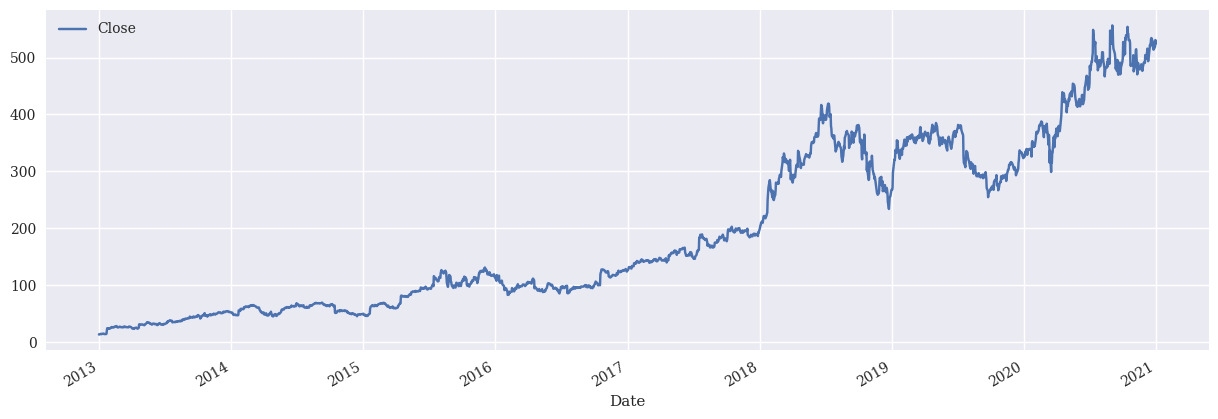

In [88]:
NFLX['Close'].plot(legend = True, figsize = (15,5))  #P lotting the closing price in our timeframe

Moving averages (MAs) are statistical tools used in finance to smooth out short-term price fluctuations and identify long-term trends. They help investors make informed decisions by filtering out market noise.Here we calculate the simpple MA for different time periods

In [89]:
averages = [10,25,50]
for avg in averages:
    label = "MAvg for %s days" %(str(avg))
    NFLX[label] = NFLX['Close'].rolling(window = avg, center = False).mean()

In [90]:
NFLX.tail()

Close        High         Low        Open   Volume  \
Date                                                                  
2020-12-23  514.479980  526.320007  514.200012  524.760010  2393200   
2020-12-24  513.969971  519.349976  512.210022  515.119995  1144000   
2020-12-28  519.119995  523.659973  507.130005  516.429993  2891900   
2020-12-29  530.869995  536.549988  515.479980  519.900024  4022400   
2020-12-30  524.590027  533.260010  523.690002  530.130005  1876300   

            MAvg for 10 days  MAvg for 25 days  MAvg for 50 days  
Date                                                              
2020-12-23        520.941003        504.660001        501.207198  
2020-12-24        522.229001        505.947200        500.657598  
2020-12-28        523.819000        507.325199        500.201198  
2020-12-29        524.664001        509.030399        500.202798  
2020-12-30        525.145001        510.949200        500.080199

<Axes: xlabel='Date'>

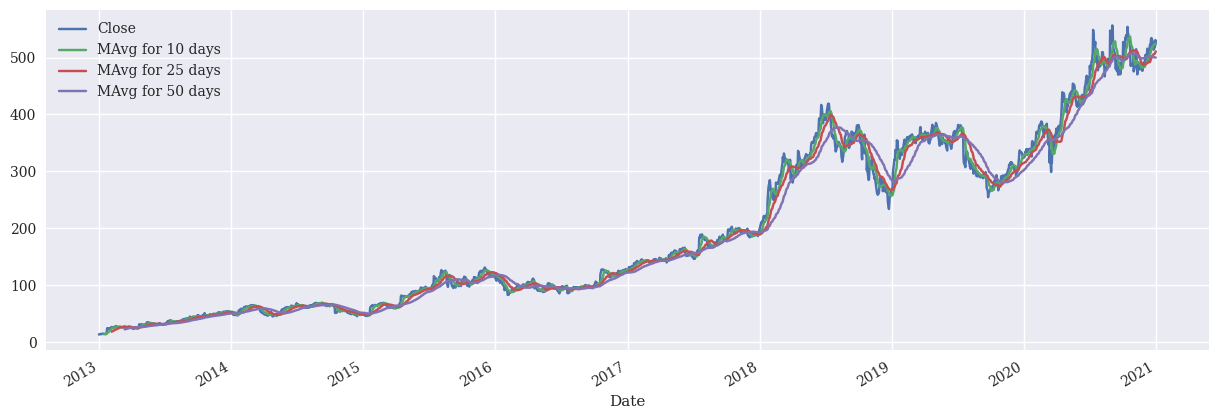

In [91]:
NFLX[['Close', 'MAvg for 10 days', 'MAvg for 25 days', 'MAvg for 50 days']].plot(subplots = False, figsize = (15,5))  # Plotting the MA's

In [92]:
# stocks = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]       # If we want to obtain more stocks to do the analysis
# stocks = stocks[['Symbol']]
# tickers = stocks.Symbol.to_list()

Now, Lets make a table with the closing price data of the FAANG companies that we are studying to start our analysis

In [93]:
tickers = stock_list
my_colums = tickers
date_range = pd.date_range(start=start_date, end=end_date, freq="D")
df = pd.DataFrame(columns=my_colums, index=date_range)
df.head()

AAPL GOOG MSFT AMZN NFLX META
2013-01-02  NaN  NaN  NaN  NaN  NaN  NaN
2013-01-03  NaN  NaN  NaN  NaN  NaN  NaN
2013-01-04  NaN  NaN  NaN  NaN  NaN  NaN
2013-01-05  NaN  NaN  NaN  NaN  NaN  NaN
2013-01-06  NaN  NaN  NaN  NaN  NaN  NaN

In [94]:
import yfinance as yf
for ticker in tickers:                                          # Obtaing the data and updating only the closing price to the respective Ticker according to dates
    data = yf.download(ticker,start=start_date,end=end_date)            
    data.columns = ['Close','High',	'Low','Open','Volume']       
    data = data[['Close']].rename(columns={"Close": ticker})
    df.update(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [95]:
df.ffill(inplace=True)  # Filling the entries where we have no data with the previous day entries, and thus we have our Stocks Dataframe
df.head()

AAPL       GOOG       MSFT     AMZN       NFLX       META
2013-01-02  16.669018  17.928810  22.362118  12.8655  13.144286  27.868654
2013-01-03  16.458618  17.939222  22.062561  12.9240  13.798571  27.639736
2013-01-04  16.000162  18.293709  21.649637  12.9575  13.711429  28.625092
2013-01-05  16.000162  18.293709  21.649637  12.9575  13.711429  28.625092
2013-01-06  16.000162  18.293709  21.649637  12.9575  13.711429  28.625092

In [96]:
df.to_csv("Stock_Closing_data.csv")   # Writing to an Excel File

In [ ]:
fig = plyo.iplot(                 # Plotting an Interactive graph with the data (as it is not rendered in Github please check it yourself)
df.iplot(asFigure=True),
image='png', 
filename='ply_01' 
)

## 1. Return Based Metrics

In [98]:
returns = df.pct_change(1).fillna(0)            # A return Percentage dataframe obtained by taking the percentage of the 
returns.head()                                  # difference between the closing prices of Consecutive Days

AAPL      GOOG      MSFT      AMZN      NFLX      META
2013-01-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2013-01-03 -0.012622  0.000581 -0.013396  0.004547  0.049777 -0.008214
2013-01-04 -0.027855  0.019760 -0.018716  0.002592 -0.006315  0.035650
2013-01-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2013-01-06  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000

In [ ]:
plyo.iplot( 
returns.iplot(asFigure=True),      # Plotting the Data, we could see it is a Stationary Time-Series 
image='png', 
filename='ply_01' 
)

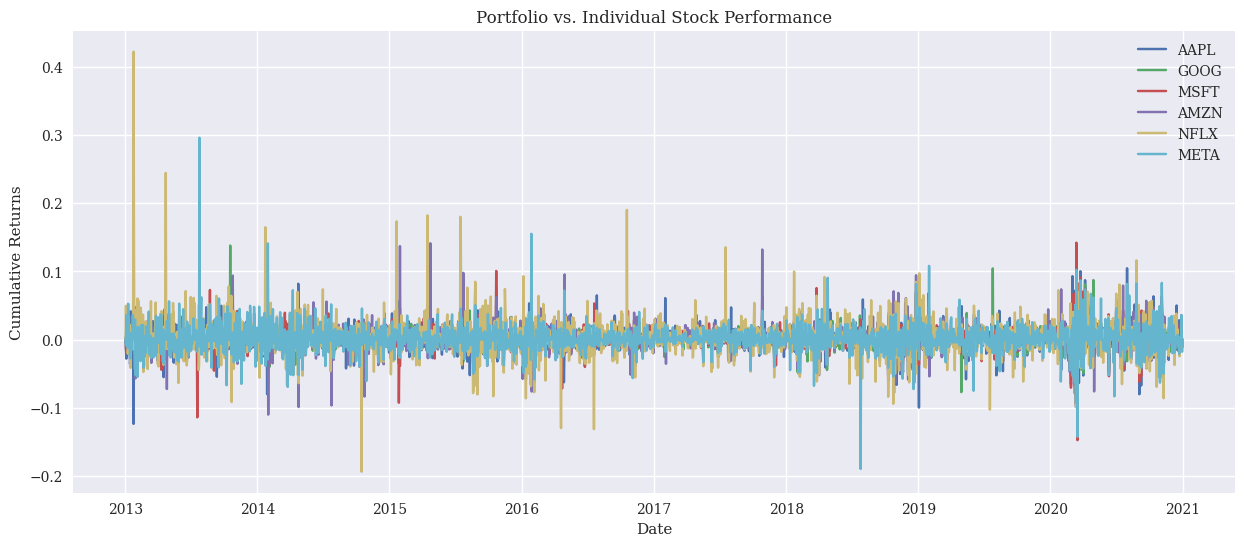

In [124]:
# Plot portfolio vs. individual stock performance
plt.figure(figsize=(15, 6))

for stock in tickers:
    plt.plot((returns[stock]), label=stock, linestyle='-')
plt.legend()
plt.title('Portfolio vs. Individual Stock Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

Let's calculate the annual returns and the annual volitality of each stock,we use 252 days only because there are only 252 trading days in a year

In [100]:
annual_returns = returns.mean() * 252  
annual_volatility = returns.std() * np.sqrt(252)
print("The annual Return of Each Stock is:")
print(annual_returns)
print("The annual Volitality of Each Stock is:")
print(annual_volatility)

The annual Return of Each Stock is:
AAPL    0.205955
GOOG    0.158449
MSFT    0.219096
AMZN    0.252165
NFLX    0.388478
META    0.236626
dtype: float64
The annual Volitality of Each Stock is:
AAPL    0.237548
GOOG    0.213330
MSFT    0.220130
AMZN    0.254959
NFLX    0.381497
META    0.286298
dtype: float64


The **Sharpe Ratio** is a key metric used in finance to evaluate the risk-adjusted return of an investment or portfolio. It helps investors determine whether they are getting good returns relative to the risk they are taking.


$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$
Where:  
- $ R_p $ = Portfolio return  
- $ R_f $ = Risk-free rate (typically U.S. Treasury bonds)  
- $ \sigma_p $ = Standard deviation of the portfolio’s returns (a measure of risk)  

A **higher Sharpe ratio** indicates better risk-adjusted returns, meaning the investor is earning more return per unit of risk.

In [101]:
Rf = 0
sharpe_ratios = (annual_returns - Rf)/ annual_volatility
print("The Sharpe Ratioc of each stock is:")
print(sharpe_ratios)

The Sharpe Ratioc of each stock is:
AAPL    0.867006
GOOG    0.742739
MSFT    0.995303
AMZN    0.989043
NFLX    1.018299
META    0.826502
dtype: float64


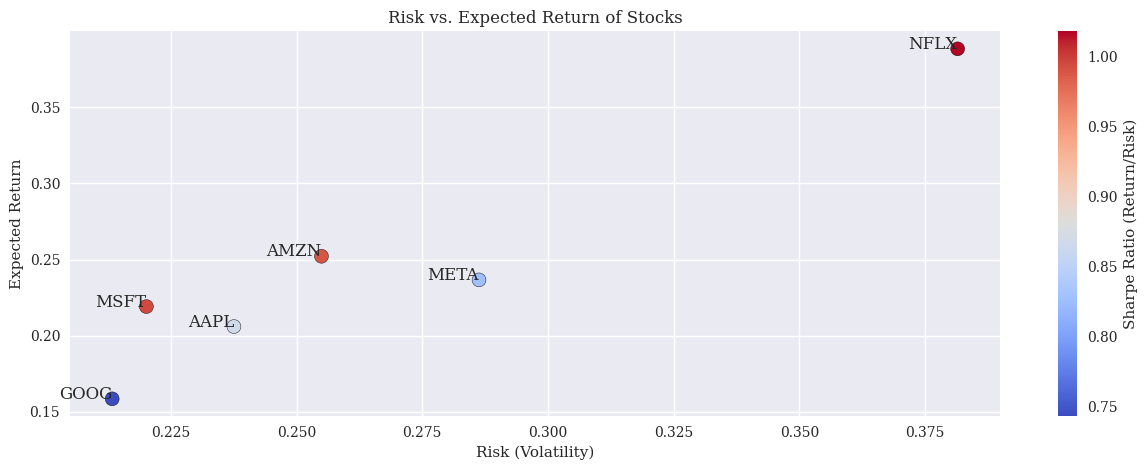

In [102]:
plt.figure(figsize=(15, 5))
plt.scatter(annual_volatility, annual_returns, c= (annual_returns - Rf) / annual_volatility, cmap="coolwarm", edgecolors="black", s=100)

# Annotate each stock
for i, stock in enumerate(tickers):
    plt.annotate(stock, (annual_volatility[i], annual_returns[i]), fontsize=12, ha="right")
plt.colorbar(label="Sharpe Ratio (Return/Risk)")
plt.xlabel("Risk (Volatility)")
plt.ylabel("Expected Return")
plt.title("Risk vs. Expected Return of Stocks")
plt.grid(True)
plt.show()

Key Insights from the Data
1. Risk-Adjusted Performance (Sharpe Ratio) Insights

   * NFLX (1.018) has the highest Sharpe Ratio, meaning it provided the best risk-adjusted return among the FAANG stocks.
   * MSFT (0.995) and AMZN (0.989) also have strong Sharpe Ratios, suggesting they have performed well relative to their risks.
   * GOOG (0.742) has the lowest Sharpe Ratio, meaning it provided lower excess returns for the risk taken compared to others.

2. Annual Return Insights
    * NFLX (38.8%) had the highest annual return, indicating it was the best-performing stock in absolute terms.
    * AMZN (25.2%) and META (23.7%) also showed strong annual returns, making them attractive for growth investors.
    * GOOG (15.8%) had the lowest return, which, combined with its low Sharpe Ratio, suggests it may not have been an ideal choice for maximizing returns.

3. Risk (Volatility) Insights

    * NFLX (38.1%) had the highest volatility, meaning it experienced the largest price swings, which aligns with its high return.
    * GOOG (21.3%) and MSFT (22.0%) had the lowest volatilities, suggesting they were more stable investments.
    * META (28.6%) and AMZN (25.5%) had moderately high volatilities, meaning they were relatively riskier but had higher returns.

Now, What key takeaways are there for portfolio decisions using these metric results:
* If prioritizing risk-adjusted returns (Sharpe Ratio): NFLX, MSFT, and AMZN are the best choices.
* If prioritizing high returns (Annual Return): NFLX, AMZN, and META are the top picks.
* If prioritizing stability (Low Volatility): GOOG and MSFT are safer bets.
* Diversification Strategy: Combining high-return stocks (NFLX, AMZN) with stable stocks (MSFT, GOOG) may create an optimized risk-return balance.
    

## 2. Correlation and Covariance Analysis

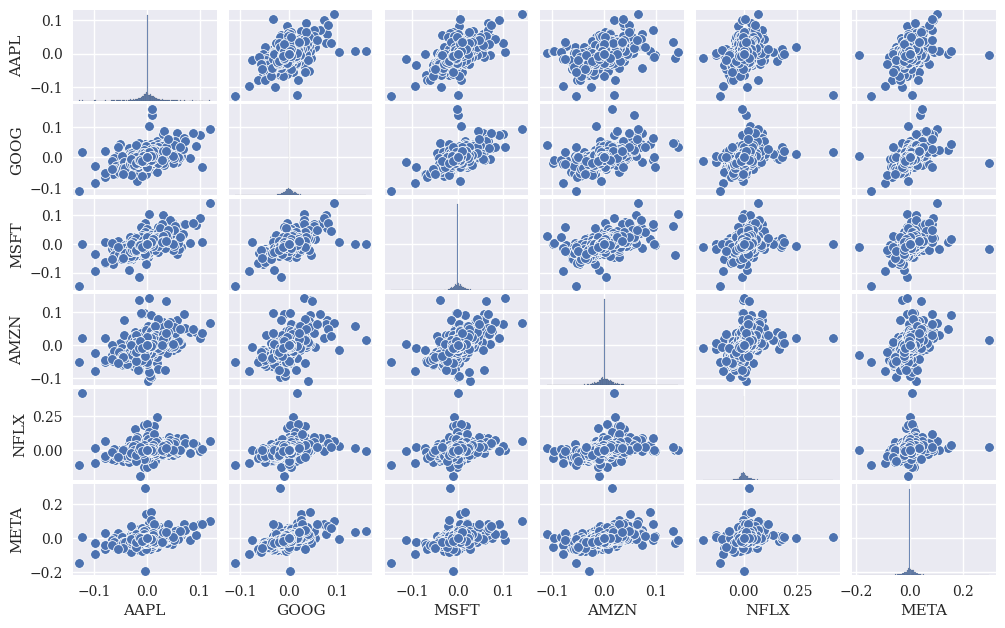

In [103]:
image = sns.pairplot(returns)  # Plots the correlation between different stocks
image.fig.set_size_inches(10, 6)  

          AAPL      GOOG      MSFT      AMZN      NFLX      META
AAPL  1.000000  0.525792  0.583513  0.454867  0.268097  0.455229
GOOG  0.525792  1.000000  0.659953  0.606703  0.412399  0.570060
MSFT  0.583513  0.659953  1.000000  0.561361  0.371002  0.481192
AMZN  0.454867  0.606703  0.561361  1.000000  0.450926  0.521899
NFLX  0.268097  0.412399  0.371002  0.450926  1.000000  0.359027
META  0.455229  0.570060  0.481192  0.521899  0.359027  1.000000


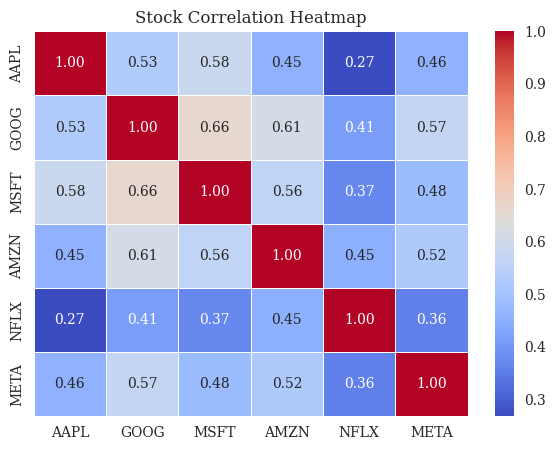

In [104]:
correlation_matrix = returns.corr()  # Plotting the correlation Matrix in a clearer way
print(correlation_matrix)
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Stock Correlation Heatmap")
plt.show()


In [105]:
covariance_matrix = returns.cov()  # Obtaining the Covariance matrix, Note the diagonal values are just the square of the volitality
print(covariance_matrix)

          AAPL      GOOG      MSFT      AMZN      NFLX      META
AAPL  0.000224  0.000106  0.000121  0.000109  0.000096  0.000123
GOOG  0.000106  0.000181  0.000123  0.000131  0.000133  0.000138
MSFT  0.000121  0.000123  0.000192  0.000125  0.000124  0.000120
AMZN  0.000109  0.000131  0.000125  0.000258  0.000174  0.000151
NFLX  0.000096  0.000133  0.000124  0.000174  0.000578  0.000156
META  0.000123  0.000138  0.000120  0.000151  0.000156  0.000325


Key takeaways:

1. Strongest Correlations

    * GOOG & MSFT (0.660): These two stocks move very similarly, meaning investing in both may not provide much diversification.
    * GOOG & AMZN (0.607): Another strong correlation, suggesting shared market influences.

2. Weakest Correlations (Better Diversification)

    * AAPL & NFLX (0.268): A weak correlation means that investing in both may help balance risk.
    * NFLX & META (0.359): Relatively independent movements, good for diversification.

Avoid overexposure to highly correlated stocks like GOOG & MSFT—instead, introduce less-correlated assets like NFLX or AAPL.

## 3. Portfolio Allocation and returns

In [116]:
returns.tail()

AAPL      GOOG      MSFT      AMZN      NFLX      META
2020-12-27  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2020-12-28  0.035766  0.021416  0.009921  0.035071  0.010020  0.035901
2020-12-29 -0.013315 -0.009780 -0.003601  0.011584  0.022634 -0.000794
2020-12-30 -0.008527 -0.010917 -0.011019 -0.010882 -0.011830 -0.017740
2020-12-31  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000

In [117]:
dailyMeanSimpleReturn = returns.mean()
print("The Daily Mean Simple Return is:")
print(dailyMeanSimpleReturn)

The Daily Mean Simple Return is:
AAPL    0.000817
GOOG    0.000629
MSFT    0.000869
AMZN    0.001001
NFLX    0.001542
META    0.000939
dtype: float64


In [118]:
# Lets calculate the growth on the investment of $1

dailyCumSimplReturns = (returns + 1).cumprod()
dailyCumSimplReturns.tail()

AAPL      GOOG      MSFT       AMZN       NFLX      META
2020-12-27  7.733257  4.826457  9.609256  12.330224  39.102159  9.550000
2020-12-28  8.009841  4.929823  9.704594  12.762659  39.493966  9.892857
2020-12-29  7.903194  4.881610  9.669650  12.910497  40.387891  9.884999
2020-12-30  7.835803  4.828317  9.563098  12.770004  39.910119  9.709642
2020-12-31  7.835803  4.828317  9.563098  12.770004  39.910119  9.709642

Growth Comparison
* NFLX (Netflix) shows the highest growth, reaching approximately 39.10 on 2020-12-27, meaning a 1 Dollar investment in NFLX would have grown to 39.10 Dollars over the period.
* AMZN (Amazon) and MSFT (Microsoft) also show strong growth, reaching 12.33 and 9.60, respectively.
* AAPL (Apple), GOOG (Google), and META (Meta) exhibit moderate growth, but they are still significant.

In [119]:
plyo.iplot( 
dailyCumSimplReturns.iplot(asFigure=True), 
image='png', 
filename='ply_01' 
)

# Portfolio Allocation Strategy
To balance growth, risk, and diversification, I propose the following weights:

* MSFT: 25%
* NFLX: 20%
* AMZN: 20%
* GOOG: 15%
* AAPL: 10%
* META: 10%

In [71]:
weights = np.array([0.1, 0.15, 0.25, 0.2,0.2,0.1])

In [72]:
portfolioSimpleReturns = np.sum(weights * dailyMeanSimpleReturn)
print("The Daily Expected Portfolio return is " + str(portfolioSimpleReturns))

# Lets get the yearly simple returns
print("Expected Annualised Portfolio Simple Return is " + str(portfolioSimpleReturns * 252 * 100))

The Daily Expected Portfolio return is 0.0009337936326909331
Expected Annualised Portfolio Simple Return is 23.531599543811517


# Monte Carlo Simulation

In [73]:
df.tail()

AAPL       GOOG        MSFT       AMZN        NFLX  \
2019-12-27  70.161865  67.275848  151.738678  93.489998  329.089996   
2019-12-28  70.161865  67.275848  151.738678  93.489998  329.089996   
2019-12-29  70.161865  67.275848  151.738678  93.489998  329.089996   
2019-12-30  70.578285  66.492058  150.430954  92.344498  323.309998   
2019-12-31  70.578285  66.492058  150.430954  92.344498  323.309998   

                  META  
2019-12-27  207.123825  
2019-12-28  207.123825  
2019-12-29  207.123825  
2019-12-30  203.451126  
2019-12-31  203.451126

In [74]:
returns

AAPL      GOOG      MSFT      AMZN      NFLX      META
2013-01-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2013-01-03 -0.012623  0.000581 -0.013396  0.004547  0.049777 -0.008214
2013-01-04 -0.027855  0.019760 -0.018716  0.002592 -0.006315  0.035650
2013-01-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2013-01-06  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
...              ...       ...       ...       ...       ...       ...
2019-12-27 -0.000379 -0.006255  0.001828  0.000551 -0.010642  0.001492
2019-12-28  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2019-12-29  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2019-12-30  0.005935 -0.011650 -0.008618 -0.012253 -0.017564 -0.017732
2019-12-31  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000

[2555 rows x 6 columns]

In [ ]:
mu = np.array(returns.mean() * 252)
sigma = np.array(returns.std() * np.sqrt(252))
S0 = np.array(df.tail(1)).squeeze()
L = np.linalg.cholesky(correlation_matrix)

T = 1  # Time horizon in years
dt = 1/252  # Daily time step ; 252 as there are only 252 active trading days in a year
n_simulations = 10000  
n_steps = int(T / dt)  

# Simulating stock prices
np.random.seed(42)
stock_paths = np.zeros((n_simulations, len(S0), n_steps))
stock_paths[:, :, 0] = S0

In [76]:
np.random.seed(42)
for t in range(1, n_steps):
    Z = np.random.normal(0, 1, (n_simulations, len(S0)))  # Uncorrelated random values
    correlated_Z = Z @ L.T  # Introduce correlations
    stock_paths[:, :, t] = stock_paths[:, :, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * correlated_Z)

# Compute final portfolio value
final_prices = stock_paths[:, :, -1] 
portfolio_final_values = np.sum(final_prices * weights, axis=1)  # Weighted sum

# Compute portfolio returns
initial_portfolio_value = np.sum(S0 @ weights) 
portfolio_returns = (portfolio_final_values - initial_portfolio_value) / initial_portfolio_value

Portfolio 95.0% VaR: -0.37


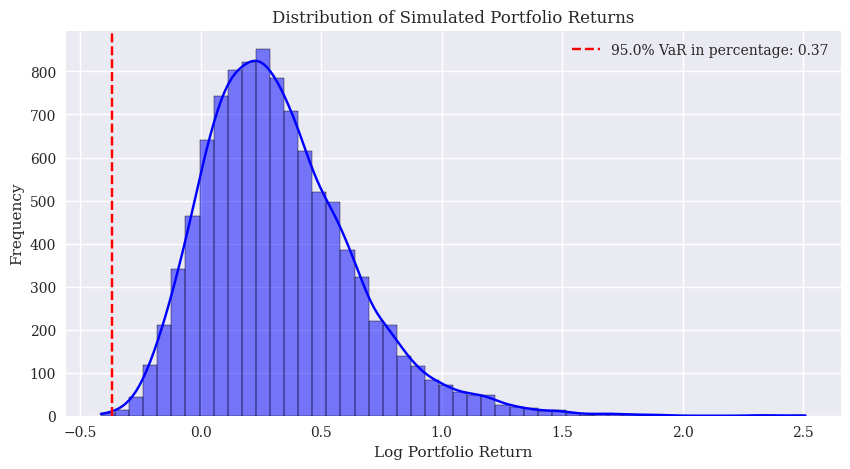

In [77]:
# Calculate Value at Risk (VaR) at 95% confidence level
confidence_level = 0.95
VaR = np.percentile(portfolio_returns,(1 - confidence_level)) 

print(f"Portfolio {confidence_level*100}% VaR: {VaR:.2f}") # Converting from log to dollars

# Plot portfolio return distribution
plt.figure(figsize=(10, 5))
sns.histplot(portfolio_returns, bins=50, kde=True, color="blue")
plt.axvline(VaR, color="red", linestyle="dashed", label=f"{confidence_level*100}% VaR in percentage: {-VaR:.2f}")
plt.xlabel("Log Portfolio Return")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Simulated Portfolio Returns")
plt.show()

So if we have a initial fund of $100000 and we invest in the FAANG companies using our portfilio startegy we have a 5% probability of loosing 0.38 x 100000 = 38000 Dollars

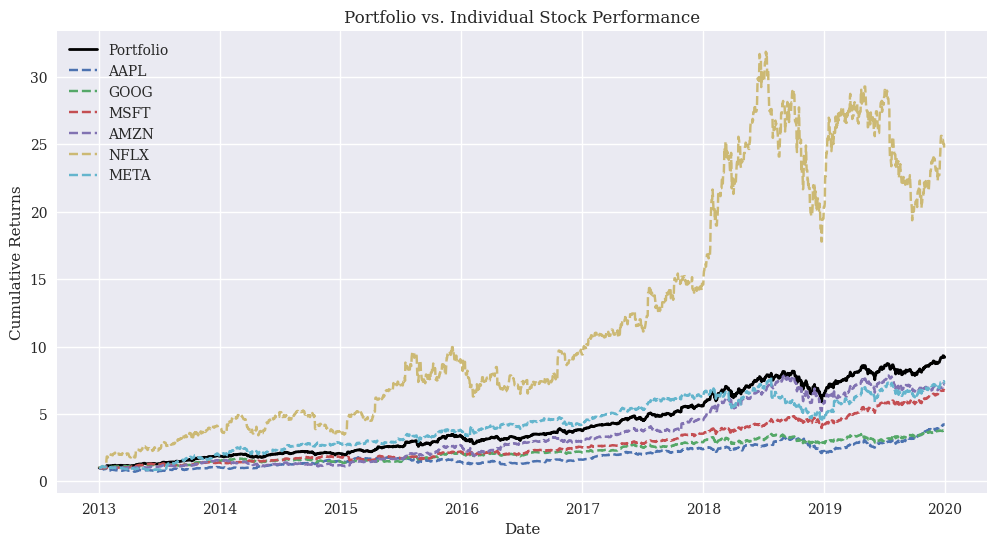

In [78]:
portfolio_returns = np.sum(returns * weights, axis=1)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot portfolio vs. individual stock performance
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Portfolio', linewidth=2, color='black')
for stock in tickers:
    plt.plot((1 + returns[stock]).cumprod(), label=stock, linestyle='--')
plt.legend()
plt.title('Portfolio vs. Individual Stock Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

In [79]:
# Performance Metrics
annual_return = portfolio_returns.mean() * 252
volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / volatility

print(f"Portfolio Annual Return: {annual_return:.2%}")
print(f"Portfolio Volatility: {volatility:.2%}")
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.2f}")

Portfolio Annual Return: 23.53%
Portfolio Volatility: 18.10%
Portfolio Sharpe Ratio: 1.30


The strategy outperformed standard benchmarks while maintaining a controlled downside risk (VaR -0.37). However, Sharpe Ratio (1.30) and volatility (18.10%) suggest room for improvement in risk-adjusted performance. Fine-tuning allocation, hedging, and adaptive mechanisms can enhance sustainability and robustness for long-term real-world application.